# 欠損値のあるデータの扱い

In [1]:
%matplotlib inline
import pandas as pd
from io import StringIO

csv_data = '''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

# If you are using Python 2.7, you need
# to convert the string to unicode:
# csv_data = unicode(csv_data)

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [2]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [5]:
from sklearn.preprocessing import Imputer

# strategy={'mean': 平均, 'median': 中央値, 'most_frequent': 最頻値}
imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df)
imputed_data = imr.transform(df.values)
imputed_data

array([[  1. ,   2. ,   3. ,   4. ],
       [  5. ,   6. ,   7.5,   8. ],
       [ 10. ,  11. ,  12. ,   6. ]])

---
# カテゴリカルデータの扱い

In [18]:
import pandas as pd

df = pd.DataFrame([['green', 'M', 10.1, 'class1'],
                   ['red', 'L', 13.5, 'class2'],
                   ['blue', 'XL', 15.3, 'class1']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


In [17]:
from sklearn.preprocessing import LabelEncoder
size_mapping = {'XL': 3, 'L': 2, 'M': 1}
class_le = LabelEncoder()
df['size'] = df['size'].map(size_mapping)
df['classlabel'] = class_le.fit_transform(df['classlabel'].values)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


### 因みに下のメソッドで一発でone-hot encoding出来る
ただし、順序特徴量（ここではサイズ）はダミー変数を作る必要は必ずしも無い。
順序特徴量間で、適正な数値への対応付けが難しい場合も多いので、one-hot化しておくのが無難

In [22]:
pd.get_dummies(df)

,price,color_blue,color_green,color_red,size_L,size_M,size_XL,classlabel_class1,classlabel_class2
0,10.1,0,1,0,0,1,0,1,0
1,13.5,0,0,1,1,0,0,0,1
2,15.3,1,0,0,0,0,1,1,0


---
# データセットの分割（train/test）

In [24]:
import numpy as np

df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [25]:
from sklearn.cross_validation import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

/Users/yoko/.anyenv/envs/pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


---
# 正規化と標準化
正規化はMax-Minでデータの区間を[0,1]に収める方法

標準化は平均を0,標準偏差を1にする方法

正規化は外れ値の影響が大きくなってしまうので、標準化の方が広く使われている。
標準化は、外れ値を標準化操作を施した後でも外れ値として扱うことが出来る。

### scikit-learn で標準化する方法↓

In [26]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [37]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train_std, y_train)
print(lr.intercept_)
print(lr.coef_)

[-0.38385686 -0.15808139 -0.70042516]
[[ 0.28040467  0.          0.         -0.02799589  0.          0.
   0.71019115  0.          0.          0.          0.          0.
   1.23614666]
 [-0.64398746 -0.06878428 -0.05721683  0.          0.          0.          0.
   0.          0.         -0.92679222  0.06017614  0.         -0.37099794]
 [ 0.          0.06151747  0.          0.          0.          0.
  -0.63561945  0.          0.          0.4978958  -0.35829198 -0.57175723
   0.        ]]


**他クラスロジスティック回帰** なので、重み行列は3行だが、切片を例に挙げると

[クラス1 vs クラス2&3 クラス2 vs クラス1&3 クラス3 vs クラス1&2]

といった感じで要素が並んでいる

---
## 正則化
正則化は、モデルのオーバーフィッティングを防ぐ方法である。正則化には以下の三種類がある。

* Lasso(L1ノルム)：特徴選択っぽい
* Ridge(L2ノルム)：どんなに正則化項を大きくしても変数は減らない（ゼロにならない）のでモデルの複雑さが減ることは無い
* Group Lasso ：　$\Sigma \Sigma ||W||^2$　の形で表現される。これは二乗でridgeっぽいけど、ridgeの正則化項の総和を単一の要素と考えると、それの単なる総和を取っていることから、本質的にはいわゆるLassoっぽい形であることが言える。よって、特徴量はLassoのようにスパースになる。

回帰ではLasso,Ridgeを組み合わせたElasticNetという正則化手法も存在する。詳しくは10章で。


### ワイン特徴量のL1正則化の効果を表したグラフ

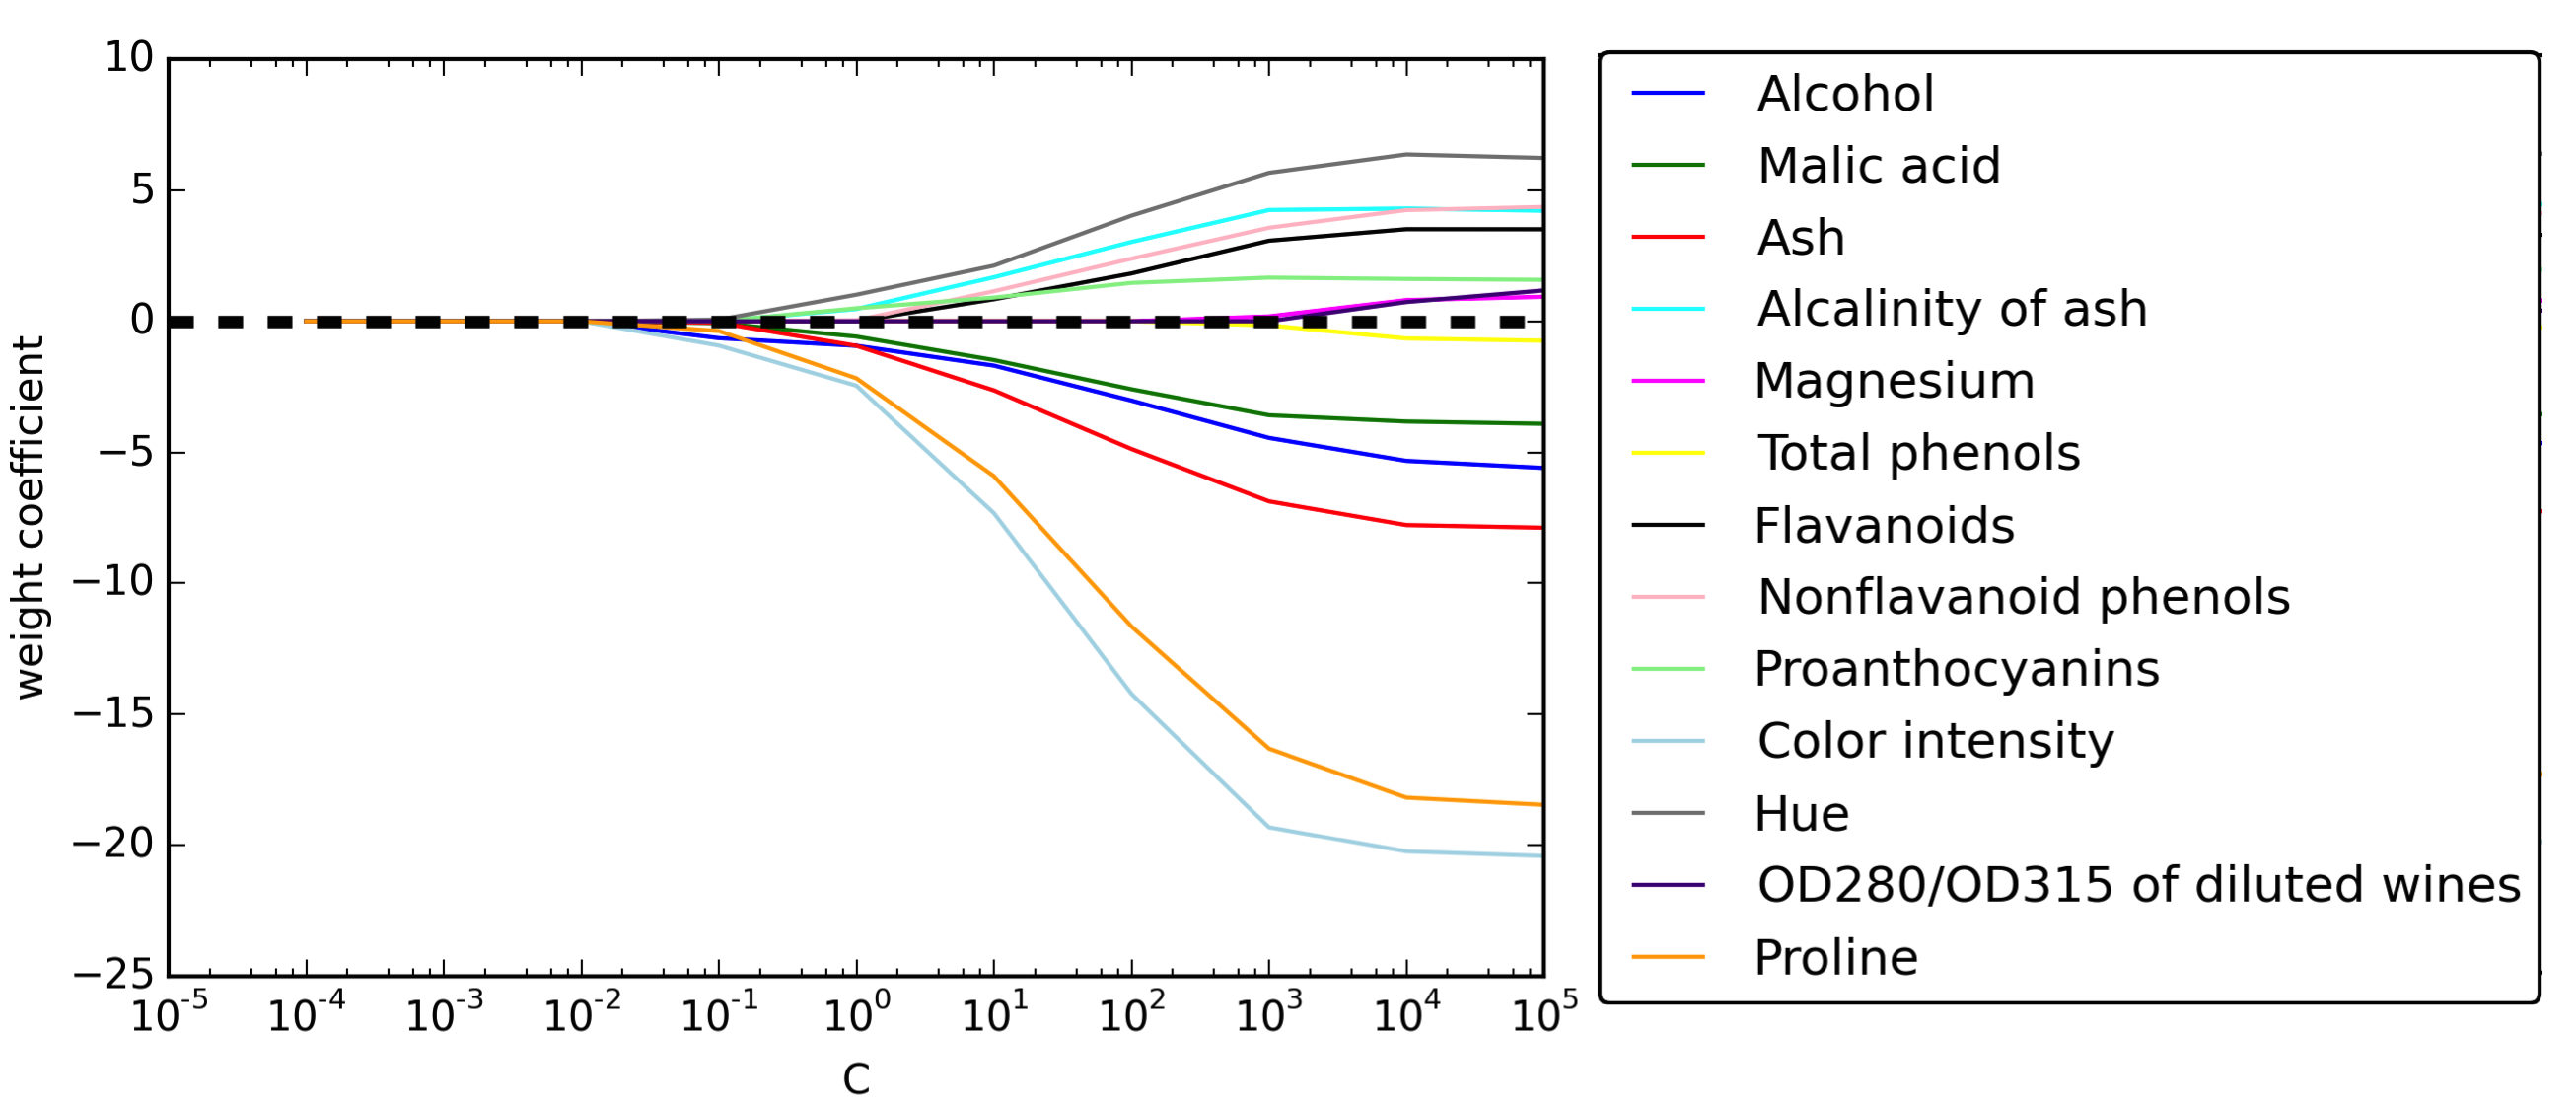

In [1]:
from IPython.display import Image
Image(filename='images/04_15.png')

# ランダムフォレストで特徴量の重要度を解析する

scikit-learnではランダムフォレストを用いて特徴量の解析や、特徴量選択することも容易に可能である。

ただし、注意する点として、ランダムフォレスト方式の特徴量選択は、特徴量同士の相関が高い時に適切に特徴量の重要度を正しく知ることが出来ないことがある。
単純にモデルの性能を良くしたいときに使うようにするべき。

 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948
 4) OD280/OD315 of diluted wines   0.131987
 5) Alcohol                        0.106589
 6) Hue                            0.078243
 7) Total phenols                  0.060718
 8) Alcalinity of ash              0.032033
 9) Malic acid                     0.025400
10) Proanthocyanins                0.022351
11) Magnesium                      0.022078
12) Nonflavanoid phenols           0.014645
13) Ash                            0.013916


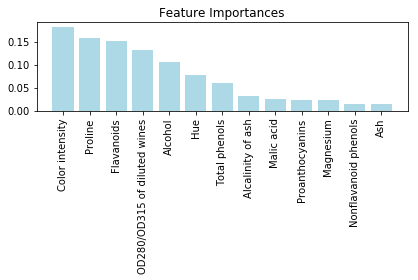

In [43]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=10000,
                                random_state=0,
                                n_jobs=-1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [47]:
# 重要度が0.15以上の特徴量を抽出
forest.transform(X_train, threshold=0.15)

/Users/yoko/.anyenv/envs/pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[  2.88000000e+00,   3.80000000e+00,   1.03500000e+03],
       [  2.04000000e+00,   2.70000000e+00,   3.12000000e+02],
       [  6.90000000e-01,   1.02000000e+01,   8.35000000e+02],
       [  5.50000000e-01,   4.00000000e+00,   8.30000000e+02],
       [  2.86000000e+00,   3.38000000e+00,   4.10000000e+02],
       [  6.00000000e-01,   5.58000000e+00,   5.70000000e+02],
       [  8.30000000e-01,   9.01000000e+00,   4.80000000e+02],
       [  2.19000000e+00,   3.95000000e+00,   1.28500000e+03],
       [  1.59000000e+00,   4.80000000e+00,   5.15000000e+02],
       [  5.80000000e-01,   5.45000000e+00,   6.50000000e+02],
       [  2.50000000e+00,   2.90000000e+00,   4.28000000e+02],
       [  1.25000000e+00,   3.40000000e+00,   3.72000000e+02],
       [  7.00000000e-01,   5.28000000e+00,   6.75000000e+02],
       [  1.79000000e+00,   3.80000000e+00,   6.30000000e+02],
       [  3.24000000e+00,   5.68000000e+00,   1.18500000e+03],
       [  5.70000000e-01,   1.95000000e+00,   5.2000000